<a href="https://colab.research.google.com/github/ralfcam/Machine-Learning/blob/master/Image_captioning_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image captioning problem

---

[Challenge Details](https://competitions.codalab.org/competitions/25195?secret_key=5ade52a5-0232-4034-85af-c28c39c928ba#learn_the_details)

## Imports


---



In [ ]:
!pip install tqdm

In [97]:
import os
import requests
import queue
import threading

from collections import defaultdict

import numpy as np
np.random.seed(7053)

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import json
import pickle

from zipfile import ZipFile
import cv2

## Get Data


---

[Downloading files with wget](https://www.gnu.org/software/wget/manual/wget.html#Download-Options)

In [ ]:
!wget -O images.zip -b "http://images.cocodataset.org/zips/train2014.zip"

--2020-06-19 13:47:15--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.45.108
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.45.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  12.58G  16.5MB/s    in 13m 48s 

2020-06-19 14:01:04 (15.6 MB/s) - ‘images.zip’ saved [13510573713/13510573713]



In [ ]:
!wget -O annotations.zip -b "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"

--2020-06-19 14:01:07--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.98.139
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.98.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations.zip’

annotations.zip     100%[===================>] 241.16M  16.7MB/s    in 16s     

2020-06-19 14:01:23 (15.0 MB/s) - ‘annotations.zip’ saved [252872794/252872794]



In [85]:
images_path = "images.zip"
annotations_path = "annotations.zip"

In [ ]:
# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.001):
  with ZipFile(fn_in) as fin, ZipFile(fn_out, "w") as fout:
      sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
      for zInfo in sampled:
          fout.writestr(zInfo, fin.read(zInfo))

In [ ]:
sample_zip(images_path, "images_samples.zip")
# sample_zip("val2014.zip", "val2014_sample.zip")

## Model Encoder


---



### Pre-trained InceptionV3 Model for CNN encoder

[![Pre-trained InceptionV3 Model for CNN encoder](https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png)](https://ai.googleblog.com/2016/03/train-your-own-image-classifier-with.html)

In [ ]:
tf.keras.backend.clear_session()
tf.__version__

'2.2.0'

In [ ]:
# we take the last hidden layer of IncetionV3 as an image embedding

tf.keras.backend.set_learning_phase(False)

model_ = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
    )

model_inputs = model_.inputs
model_output = model_.output

preprocess_for_model = tf.keras.applications.inception_v3.preprocess_input

cnn_encoder = tf.keras.Model(
    model_inputs,
    tf.keras.layers.GlobalAveragePooling2D()(model_output)
    )

In [ ]:
# cnn_encoder.get_config()

### Extract train features

### Util Functions

In [74]:
def apply_model(zip_fn, model, preprocess_for_model, extensions=(".jpg",),
                input_shape=(224, 224), batch_size=32):
    # queue for cropped images
    q = queue.Queue(maxsize=batch_size * 10)

    # when read thread put all images in queue
    read_thread_completed = threading.Event()

    # time for read thread to die
    kill_read_thread = threading.Event()

    def reading_thread(zip_fn):
        zf = ZipFile(zip_fn)
        for fn in zf.namelist():
            if kill_read_thread.is_set():
                break
            if os.path.splitext(fn)[-1] in extensions:
                buf = zf.read(fn)  # read raw bytes from zip for fn
                img = decode_image_from_buf(buf)  # decode raw bytes
                img = crop_and_preprocess(img, input_shape, preprocess_for_model)
                while True:
                    try:
                        q.put((os.path.split(fn)[-1], img), timeout=1)  # put in queue
                    except queue.Full:
                        if kill_read_thread.is_set():
                            break
                        continue
                    break

        read_thread_completed.set()  # read all images

    # start reading thread
    t = threading.Thread(target=reading_thread, args=(zip_fn,))
    t.daemon = True
    t.start()

    img_fns = []
    img_embeddings = []

    batch_imgs = []

    def process_batch(batch_imgs):
        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_embeddings = model.predict(batch_imgs)
        img_embeddings.append(batch_embeddings)

    try:
        while True:
            try:
                fn, img = q.get(timeout=1)
            except queue.Empty:
                if read_thread_completed.is_set():
                    break
                continue
            img_fns.append(fn)
            batch_imgs.append(img)
            if len(batch_imgs) == batch_size:
                process_batch(batch_imgs)
                batch_imgs = []
            q.task_done()
        # process last batch
        if len(batch_imgs):
            process_batch(batch_imgs)
    finally:
        kill_read_thread.set()
        t.join()

    q.join()

    img_embeddings = np.vstack(img_embeddings)
    return img_embeddings, img_fns


def save_pickle(obj, fn):
    with open(fn, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def decode_image_from_buf(buf):
    img = cv2.imdecode(np.asarray(bytearray(buf), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def crop_and_preprocess(img, input_shape, preprocess_for_model):
    img = image_center_crop(img)  # take center crop
    img = cv2.resize(img, input_shape)  # resize for our model
    img = img.astype("float32")  # prepare for normalization
    img = preprocess_for_model(img)  # preprocess for model
    return img


def image_center_crop(img):
    h, w = img.shape[0], img.shape[1]
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = 0
    if h > w:
        diff = h - w
        pad_top = diff - diff // 2
        pad_bottom = diff // 2
    else:
        diff = w - h
        pad_left = diff - diff // 2
        pad_right = diff // 2
    return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]



### Fit Encoder

In [78]:
IMG_SIZE = 299
train_img_embeds, train_img_fns = apply_model(
    images_path, cnn_encoder, preprocess_for_model, 
    input_shape=(IMG_SIZE, IMG_SIZE)
    )

save_pickle(train_img_embeds, "train_img_embeds.pickle")
save_pickle(train_img_fns, "train_img_fns.pickle")

## Checkpoint

---



In [81]:
def read_pickle(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)

In [83]:
# load prepared embeddings
train_img_embeds = read_pickle("train_img_embeds.pickle")
train_img_fns = read_pickle("train_img_fns.pickle")
# val_img_embeds = read_pickle("val_img_embeds.pickle")
# val_img_fns = read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
# print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783


## Prepare Image Captions

In [99]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))


def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = ZipFile(images_path)
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = decode_image_from_buf(zf.read(example))
    plt.imshow(image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()


In [ ]:
train_captions = get_captions_for_fns(train_img_fns, annotations_path, 
                                      "annotations/captions_train2014.json")

# val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
#                                       "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
# print(len(val_img_fns), len(val_captions))

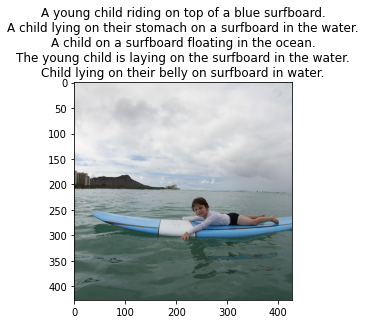

In [109]:
# look at training example (each has 5 captions)
pick_one = np.random.choice(len(train_img_fns))
show_trainig_example(train_img_fns, train_captions, example_idx=pick_one)